# Introduction

The Boston Crime dataset contains the categories, locations and dates all crime that happened in Boston between 2016 and 2018. In the following EDA, I will take a closer look at the data and provide some interesting insights.

Changelog
* v1.0 Draft notebook.
* v1.1 Additional plots added.
* v1.2 Added comments to the notebook.
* v1.3 Additional commenting, questions, plots added. Updating the visuals.

**Data preparation and cleaning**

In [1]:
# Library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import seaborn as sns
import datetime
import folium #Geoploting library
from folium.plugins import HeatMap 
%matplotlib inline

In [2]:
#Importing the dataset
df = pd.read_csv(r"../input/crimes-in-boston/crime.csv",encoding = 'unicode_escape')

In [3]:
#List of columns to drop
columns_to_drop = ["INCIDENT_NUMBER", #Unneccecary
                  "OFFENSE_CODE", #Better to use group
                  "OFFENSE_DESCRIPTION", #Better to use group
                  "REPORTING_AREA", #Not needed
                  "UCR_PART", #Not needed
                  "Location"] #Loc and Lat columns are already there

#Apply the column drop
df.drop(columns_to_drop, axis=1, inplace=True)

#Replace the -1 in the Lat & Long column with NaN
df["Lat"].replace(-1,np.nan,inplace=True)
df["Lat"].replace(-1,np.nan,inplace=True)

#Adding a "No" to the shooting column
df["SHOOTING"].fillna("N", inplace=True)

#Converting to datetime
df["OCCURRED_ON_DATE"] = pd.to_datetime(df["OCCURRED_ON_DATE"])

#Renaming some crimes
rename_crimes = {"INVESTIGATE PERSON": "Investigate Person",
                         "HUMAN TRAFFICKING" : "Human Trafficking",
                         "HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE": "Involuntary Servitude"}
df["OFFENSE_CODE_GROUP"].replace(rename_crimes,inplace=True)

# **General look at the data**

Text(-1.1, 112000, 'The total number of crimes committed each year in the Boston area (2015-2018).')

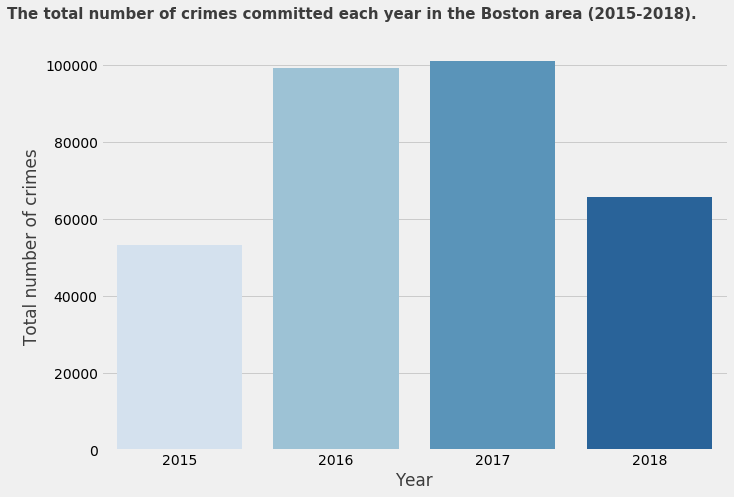

In [4]:
#Define plot style
plt.style.use("fivethirtyeight")

fig, ax = plt.subplots(figsize=(10,7))

#Plot
sns.catplot(x="YEAR", kind="count", palette="Blues", data=df, ax=ax)
plt.close(2)

plt.xlabel("Year", alpha=0.75)
plt.ylabel("Total number of crimes", alpha=0.75)

ax.text(x=-1.1,y=112000,s="The total number of crimes committed each year in the Boston area (2015-2018).",weight="bold",alpha=0.75, fontsize=15)

Text(-1.1, 10000, 'The total number of crimes committed each month in the Boston area (2015-2018).')

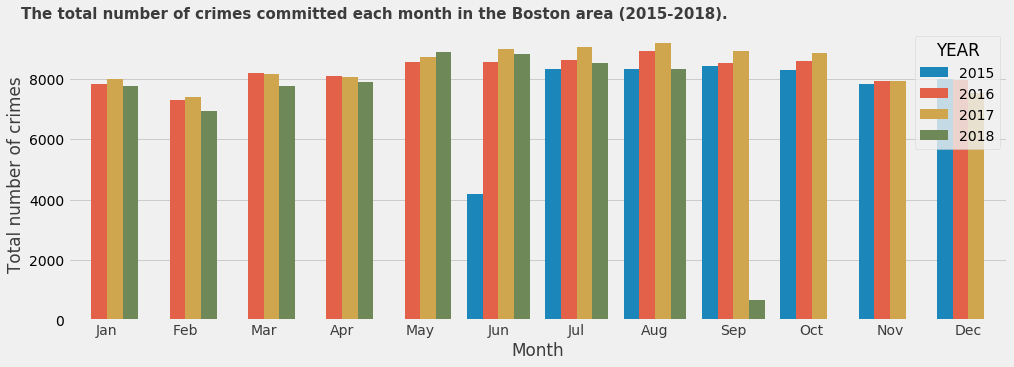

In [5]:
fig, ax = plt.subplots(figsize=(15,5))

#
sns.catplot(x="MONTH", hue="YEAR", kind="count", data=df, ax=ax)
plt.close(2)
plt.xlabel("Month", alpha=0.75)
plt.ylabel("Total number of crimes", alpha=0.75)

ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],alpha=0.75)

#Title
ax.text(x=-1.1,y=10000,s="The total number of crimes committed each month in the Boston area (2015-2018).",weight="bold",alpha=0.75, fontsize=15)


Notice how the data for both 2016 and 2018 abruptly stops. The half-completed months will be a problem when looking at monthly data as they will have less crime in total. This is something we have to keep in mind going forward.

**Monthly crime**

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


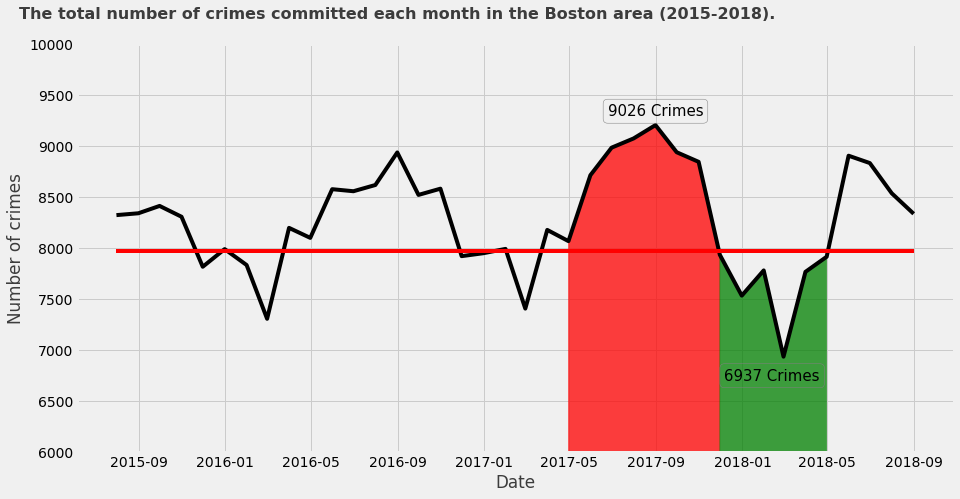

In [6]:
crimes_per_month = df.set_index("OCCURRED_ON_DATE") #Set datetime as index
crimes_m = pd.DataFrame(crimes_per_month.resample("M").agg(dict(OFFENSE_CODE_GROUP="size"))) #Resample on a monthly basis
crimes_m["mean"] = crimes_m["OFFENSE_CODE_GROUP"].mean() #Calculate the mean for the data

# Remove two incomplete dates
incomplete_dates = ["2018-09-30", "2015-06-30"]
crimes_m = crimes_m.drop(pd.to_datetime(incomplete_dates))

fig, ax = plt.subplots(figsize=(14, 7))


plt.plot(crimes_m["OFFENSE_CODE_GROUP"], label="Crimes per month", color="black")
plt.plot(crimes_m["mean"], label="Mean montly crime", color="r", linewidth=4)

#Highs Lows
high = crimes_m[crimes_m.index >= "2017-04-30"]
high = high[high.index <= "2017-11-30"]
low = crimes_m[crimes_m.index >= "2017-11-30"]
low = low[low.index <= "2018-04-30"]

plt.fill_between( high.index, high["OFFENSE_CODE_GROUP"], color="red", alpha=0.75)
plt.fill_between( low.index, low["OFFENSE_CODE_GROUP"], color="green", alpha=0.75)

ax.annotate("6937 Crimes", xy=('2018-02-12', 7000),  xycoords='data',size=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            xytext=(0, -30), textcoords='offset points', ha='center')
ax.annotate("9026 Crimes", xy=("2017-08-31", 9200),  xycoords='data',size=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            xytext=(0, 10), textcoords='offset points', ha='center')

plt.xlabel("Date", alpha=0.75)
plt.ylabel("Number of crimes", alpha=0.75)
plt.ylim(6000,10000)

#Title
ax.text(x="2015-03-15",y=10250,s="The total number of crimes committed each month in the Boston area (2015-2018).",weight="bold",alpha=0.75, fontsize=16)

del high, low, crimes_m

Both the peak and valley for crime was marked on the plot above. Additionally, the mean value was placed as a point of reference. We will take the year with the peak and plot it next to the average temperature of the city. To make sure that we are doing this correctly, I have enabled the shared x-axis function.

In [7]:
#The most crimes happened in a 2017 month so we are going to find temperature data from it
date = ["31.1.2017","28.2.2017","31.3.2017","30.4.2017","31.5.2017","30.6.2017","31.7.2017","31.8.2017","30.9.2017","31.10.2017","30.11.2017"
        ,"31.12.2017"]
avrg_temp = [35.15,36.65,34.05,51.65,56.35,69.5,72.5,72,67.1,61.35,43.75,30.75]
temperature_data = pd.DataFrame(date,columns=["Date"])
temperature_data["Date"] = pd.to_datetime(temperature_data["Date"])
temperature_data["F Temperate"] = avrg_temp

Text(2016-12-15, 9500, 'High correlation pattern between the number of crimes and hight of the temperature in the Boston area.')

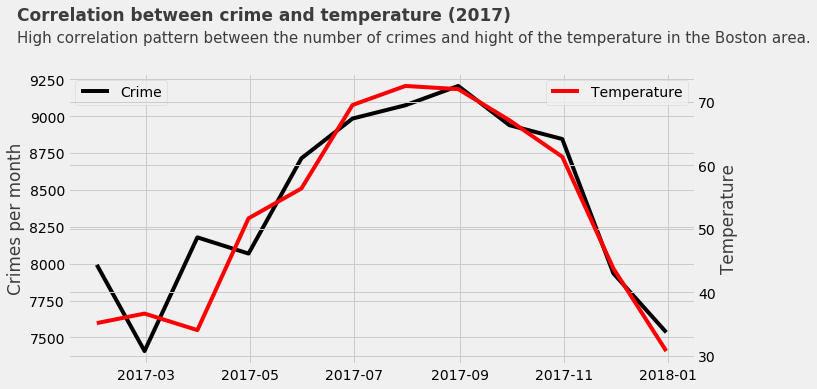

In [8]:
df_month_2017 = df[df["YEAR"]==2017]
df_month_2017 = df_month_2017.set_index(df_month_2017["OCCURRED_ON_DATE"]).resample("M").agg({"OFFENSE_CODE_GROUP" : "size"})

fig, ax1 = plt.subplots(figsize=(10,5))

#Plot

ax2 = ax1.twinx()

ax1.plot(df_month_2017.index,df_month_2017["OFFENSE_CODE_GROUP"],label="Crime",color="black")
ax2.plot(temperature_data["Date"],temperature_data["F Temperate"],label="Temperature",color="r")

ax2.legend()
ax1.legend(loc="upper left")

plt.xlabel("Date", alpha=0.75)
ax1.set_ylabel("Crimes per month", alpha=0.75)
ax2.set_ylabel("Temperature", alpha=0.75)

#Title

ax1.text(x="2016-12-15",y=9650,s="Correlation between crime and temperature (2017)",weight="bold",alpha=0.75, fontsize=17)
ax1.text(x="2016-12-15",y=9500,s="High correlation pattern between the number of crimes and hight of the temperature in the Boston area.",alpha=0.75, fontsize=15)

There is an interesting correlation between high temperatures and the rise of crime in the city.

**Daily and hourly crime**

Text(-0.75, 55000, 'Daily and hourly number of crimes in the Boston area.')

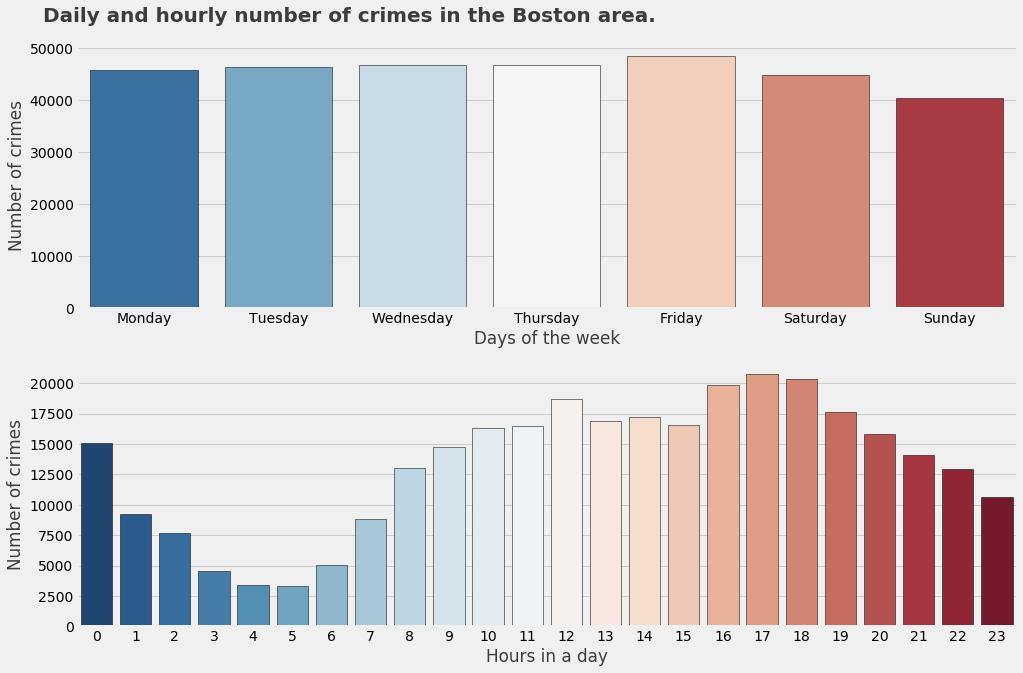

In [9]:
#Data
day_order = ["Monday", "Tuesday", "Wednesday","Thursday","Friday","Saturday","Sunday"]

fig,(ax1,ax2) = plt.subplots(2,1, figsize=[15,10])

sns.countplot("DAY_OF_WEEK", data=df,order=day_order,palette="RdBu_r",edgecolor="black", ax = ax1)
ax1.set_xlabel("Days of the week", alpha=0.75)
ax1.set_ylabel("Number of crimes", alpha=0.75)

sns.countplot("HOUR", data=df,palette="RdBu_r",edgecolor="black", ax = ax2)
ax2.set_xlabel("Hours in a day", alpha=0.75)
ax2.set_ylabel("Number of crimes", alpha=0.75)

ax1.text(x=-0.75,y=55000,s="Daily and hourly number of crimes in the Boston area.",weight="bold",alpha=0.75, fontsize=20)

We can see that crime takes a bit of a break during Sunday. If we look at the hours we can see that the least crime happens in 05:00 in the morning while the most crime happens around 16:00 to 18:00. This can potentially be related to the end of the workday and people travelling back home. It might be worth investigating in the future.

We are going to look into all the data we have available to plot a line graph with an upper and lower control limit. This will help us identify outliers that we can further investigate.

In [10]:
crime_per_day = df.set_index("OCCURRED_ON_DATE")

In [11]:
crimes = pd.DataFrame(crime_per_day.resample("D").size())
crimes["mean"] = crime_per_day.resample("D").size().mean()
crimes["std"] = crime_per_day.resample("D").size().std()
UCL = crimes["mean"] + 3 * crimes["std"]
LCL = crimes["mean"] - 3 * crimes["std"]

Text(2015-03-01, 400, 'The points beyond the upper and lower control limits signal that the data points are uncommon and need to look at further.')

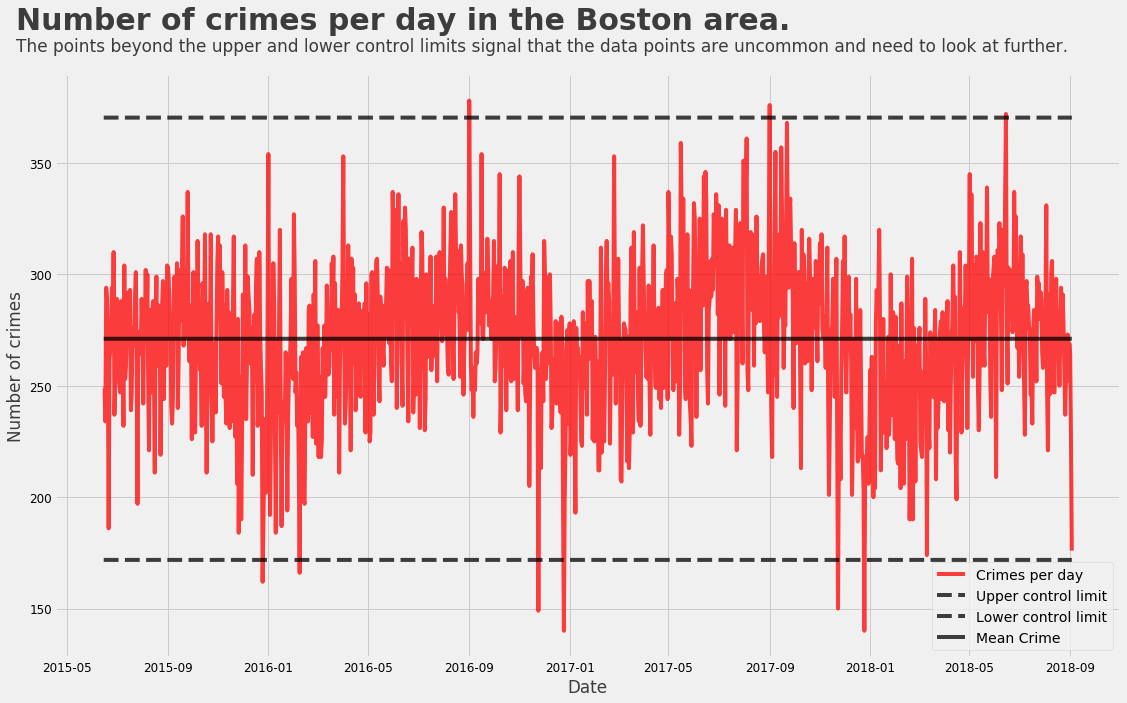

In [12]:
fig, ax = plt.subplots(figsize=(17, 10))


ax.plot(crimes[[0]],color="red", alpha=0.75, label="Crimes per day")
ax.plot(UCL, color="black",linewidth=4,linestyle="dashed",alpha=0.75,label="Upper control limit")
ax.plot(LCL, color="black",linewidth=4,linestyle="dashed",alpha=0.75,label="Lower control limit")
ax.plot(crimes["mean"], color="black",linewidth=4,alpha=0.75, label="Mean Crime")
ax.tick_params(labelsize=12)

ax.set_xlabel("Date", alpha=0.75)
ax.set_ylabel("Number of crimes", alpha=0.75)

plt.legend(loc="lower right")
ax.text(x="2015-03-01",y=410,s="Number of crimes per day in the Boston area.",weight="bold",alpha=0.75, fontsize=30)
ax.text(x="2015-03-01",y=400,s="The points beyond the upper and lower control limits signal that the data points are uncommon and need to look at further.",alpha=0.75, fontsize=17)

We can see a few outliers that happen around the end of the year. This can potentially be related to the holiday season and we will investigate this further. To do this, we will take only the data from 2017 and plot it in a daily life graph pointing at the most popular holidays of the year.

In [13]:
crime_per_day_2017 = crime_per_day[crime_per_day["YEAR"] == 2017]
crimes_2017 = pd.DataFrame(crime_per_day_2017.resample("D").size())

Text(2016-12-10, 370, 'Some spikes and valleys can be explained by certain holidays that occurred.')

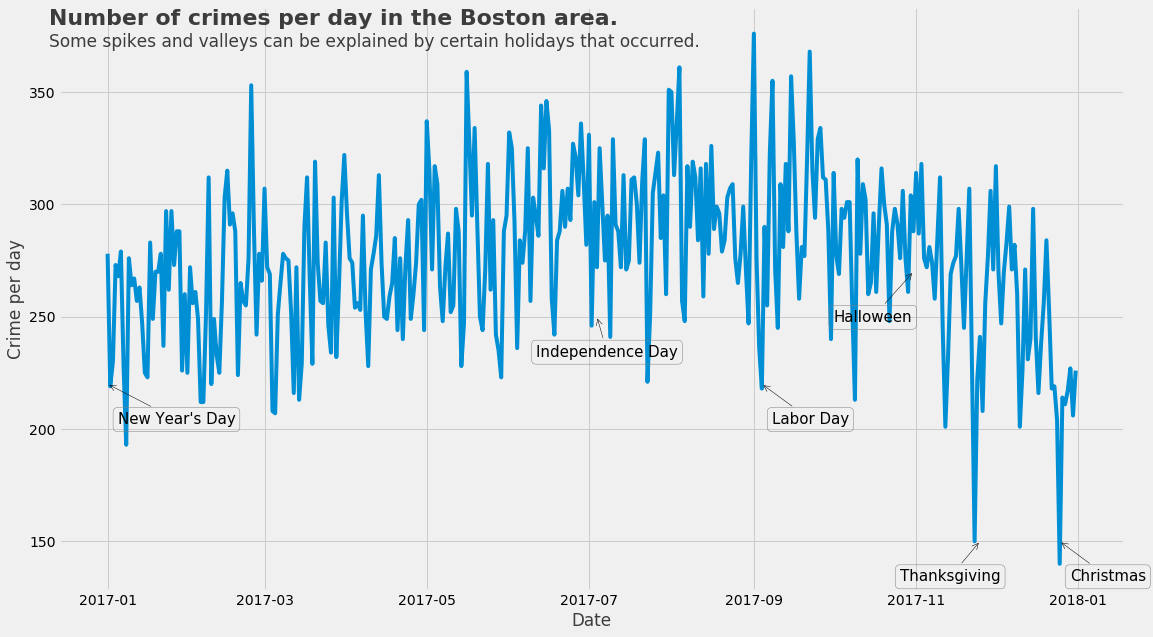

In [14]:
fig, ax = plt.subplots(figsize=(17, 10))

#Plot
ax.plot(crimes_2017[[0]], label="Crimes per day")

#Annotations
ax.annotate("Independence Day", xy=('2017-7-4', 250),  xycoords='data',size=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            xytext=(10, -40), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->",color="black"))
ax.annotate("New Year's Day", xy=('2017-1-1', 220),  xycoords='data',size=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            xytext=(10, -40), textcoords='offset points', ha='left',
            arrowprops=dict(arrowstyle="->",color="black"))
ax.annotate("Labor Day", xy=('2017-9-4', 220),  xycoords='data',size=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            xytext=(10, -40), textcoords='offset points', ha='left',
            arrowprops=dict(arrowstyle="->",color="black"))
ax.annotate("Halloween", xy=('2017-10-31', 270),  xycoords='data',size=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            xytext=(-80, -50), textcoords='offset points', ha='left',
            arrowprops=dict(arrowstyle="->",color="black"))
ax.annotate("Thanksgiving", xy=('2017-11-25', 150),  xycoords='data',size=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            xytext=(-80, -40), textcoords='offset points', ha='left',
            arrowprops=dict(arrowstyle="->",color="black"))
ax.annotate("Christmas", xy=('2017-12-25', 150),  xycoords='data',size=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            xytext=(10, -40), textcoords='offset points', ha='left',
            arrowprops=dict(arrowstyle="->",color="black"))

#Plot elements
ax.set_xlabel("Date", alpha=0.75)
ax.set_ylabel("Crime per day", alpha=0.75)

#Title
ax.text(x="2016-12-10",y=380,s="Number of crimes per day in the Boston area.",weight="bold",alpha=0.75, fontsize=22)
ax.text(x="2016-12-10",y=370,s="Some spikes and valleys can be explained by certain holidays that occurred.",alpha=0.75, fontsize=17)

Holidays can have a major impact on crime. People are leaving town to visit family, public gatherings are more frequent and people tend to celebrate those days. All of the before mentioned factors have an effect on the number and types of crimes committed.

# **Most and least frequent crimes**

Text(-0.1, 0.95, 'Most frequent crimes in the Boston area (2015-2017).')

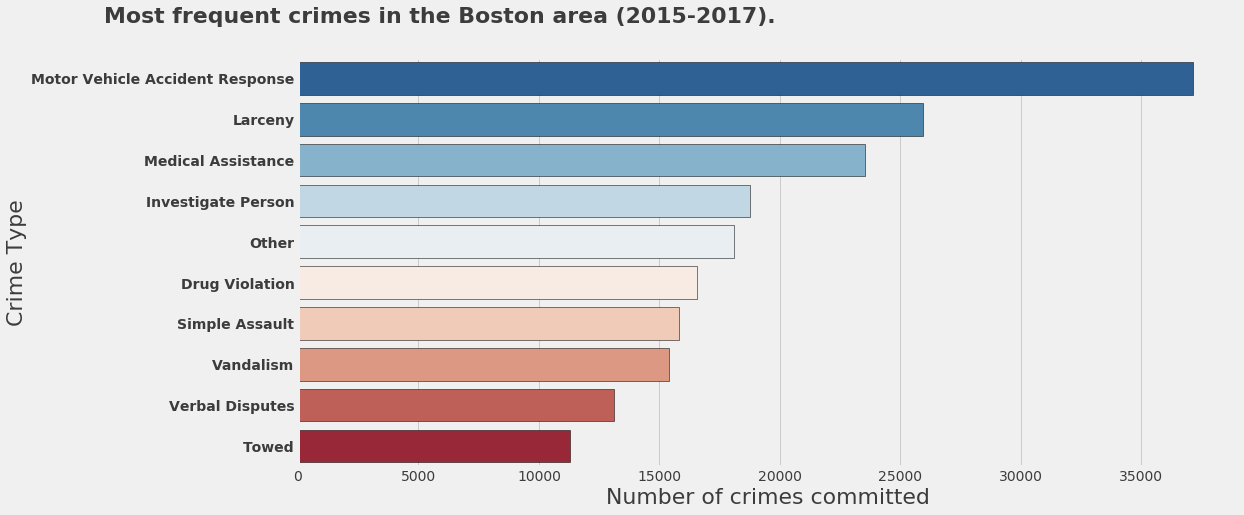

In [15]:
ax,fig = plt.subplots(figsize=(15,7))

#Plot
sns.countplot(y = df["OFFENSE_CODE_GROUP"],order=df["OFFENSE_CODE_GROUP"].value_counts()[:10].index, palette="RdBu_r",edgecolor="black")

plt.ylabel("Crime Type", fontsize=22, alpha=.75)
plt.xlabel("Number of crimes committed", fontsize=22, alpha=.75)

plt.yticks(alpha=0.75,weight="bold")
plt.xticks(alpha=0.75)

#Title
ax.text(x=-0.10,y=0.95,s="Most frequent crimes in the Boston area (2015-2017).",weight="bold",alpha=0.75, fontsize=22)

Text(-0.05, 0.95, 'Least frequent crimes in the Boston area (2015-2017).')

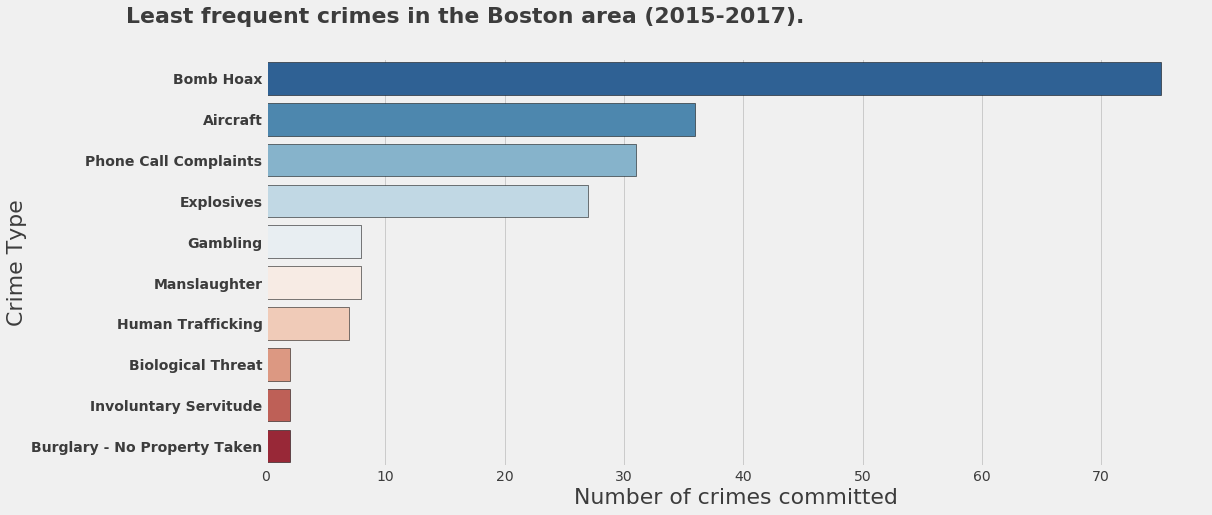

In [16]:
ax,fig = plt.subplots(figsize=(15,7))

#Plot
sns.countplot(y = df["OFFENSE_CODE_GROUP"],order=df["OFFENSE_CODE_GROUP"].value_counts()[-10:].index, palette="RdBu_r",edgecolor="black")

plt.ylabel("Crime Type", fontsize=22, alpha=.75)
plt.xlabel("Number of crimes committed", fontsize=22, alpha=.75)

plt.yticks(alpha=0.75,weight="bold")
plt.xticks(alpha=0.75)

#Title
ax.text(x=-0.05,y=0.95,s="Least frequent crimes in the Boston area (2015-2017).",weight="bold",alpha=0.75, fontsize=22)

# **Most frequent crimes on Christmas**

In [17]:
christmas_crime = df[df["OCCURRED_ON_DATE"] >= "2017-12-25"]
christmas_crime = christmas_crime[christmas_crime["OCCURRED_ON_DATE"] < "2017-12-26"]

Text(-0.05, 0.95, 'Most frequent crimes on Christmas in the Boston area (2015-2017).')

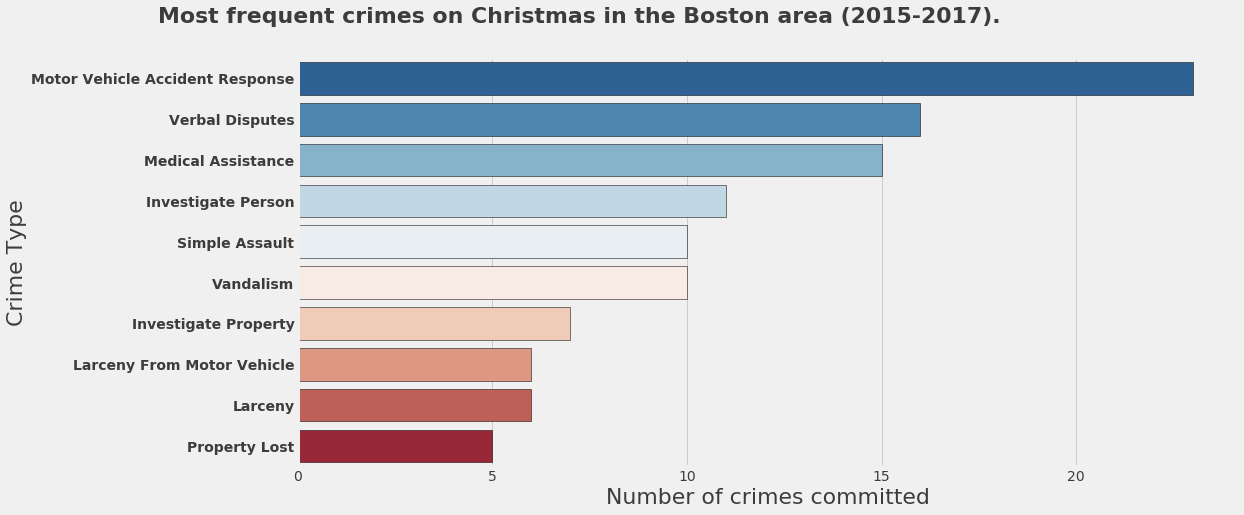

In [18]:
ax,fig = plt.subplots(figsize=(15,7))

#Plot
sns.countplot(y = christmas_crime["OFFENSE_CODE_GROUP"],order=christmas_crime["OFFENSE_CODE_GROUP"].value_counts()[:10].index, palette="RdBu_r",edgecolor="black")

plt.ylabel("Crime Type", fontsize=22, alpha=.75)
plt.xlabel("Number of crimes committed", fontsize=22, alpha=.75)

plt.yticks(alpha=0.75,weight="bold")
plt.xticks(alpha=0.75)

#Title
ax.text(x=-0.05,y=0.95,s="Most frequent crimes on Christmas in the Boston area (2015-2017).",weight="bold",alpha=0.75, fontsize=22)

It appears that verbal and simple assaults are more frequent during Christmas as they moved a few places.

In [19]:
christmas_crime_map = folium.Map(location=[42.3601, -71.0589],
              zoom_start = 12)
christmas_crime_loc = christmas_crime[["Lat", "Long"]]
christmas_crime_loc.dropna(inplace=True)
HeatMap(christmas_crime_loc, radius = 20).add_to(christmas_crime_map)
display(christmas_crime_map)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


**Gun crime**

In [20]:
gun_crime_df = crime_per_day[crime_per_day["SHOOTING"] == "Y"]
gun_crime_per_day = pd.DataFrame(gun_crime_df.resample("M").size())
gun_crime_per_day["mean"] = gun_crime_df.resample("M").size().mean()

Text(2015-05-01, 50, 'Daily gun crime in the Boston area(2015-2018).')

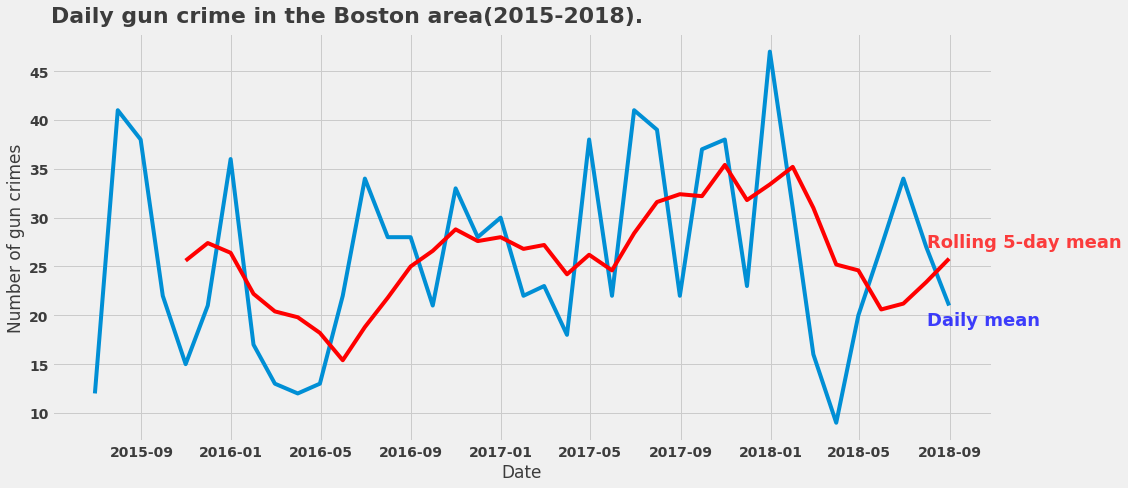

In [21]:
#Ploting with an window = 5 or SMA = 5 rolling mean.
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(gun_crime_per_day[[0]], label = "Gun crime per day")
ax.plot(gun_crime_per_day[[0]].rolling(window=5).mean(), color = "red", label="Gun crime rolling mean")

plt.ylabel("Number of gun crimes", fontsize=17, alpha=0.75)
plt.xlabel("Date", fontsize=17,alpha=0.75)

plt.xticks(fontsize=14,alpha=0.75,weight="bold")
plt.yticks(fontsize=14,alpha=0.75,weight="bold")

ax.text(x="2018-08-01",y=27,s="Rolling 5-day mean",weight="bold",color="red",alpha=0.75, fontsize=18)
ax.text(x="2018-08-01",y=19,s="Daily mean",weight="bold",color="blue",alpha=0.75, fontsize=18)

#Title
ax.text(x="2015-05-01",y=50,s="Daily gun crime in the Boston area(2015-2018).",weight="bold",color="black",alpha=0.75, fontsize=22)

On the daily gun crime plot, we can observe that the number of gun-related crimes has remained fairly consistent during the years. This needs to be investigated further and we will do so by plotting the location of the gun-related crimes and the most frequent crimes where guns are involved.

In [22]:
boston_shooting_map = folium.Map(location=[42.3601, -71.0589],
              zoom_start = 12)
shooting_location = gun_crime_df[["Lat", "Long"]]
shooting_location.dropna(inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [23]:
HeatMap(shooting_location, radius = 20).add_to(boston_shooting_map)
display(boston_shooting_map)

In [24]:
crimes_with_guns = gun_crime_df["OFFENSE_CODE_GROUP"].value_counts()[:10]
top_gun_crimes = gun_crime_df[gun_crime_df["OFFENSE_CODE_GROUP"].isin(crimes_with_guns.index)]

Text(-0.05, 0.95, 'Most frequent crimes that involve gun violence (2015-2017).')

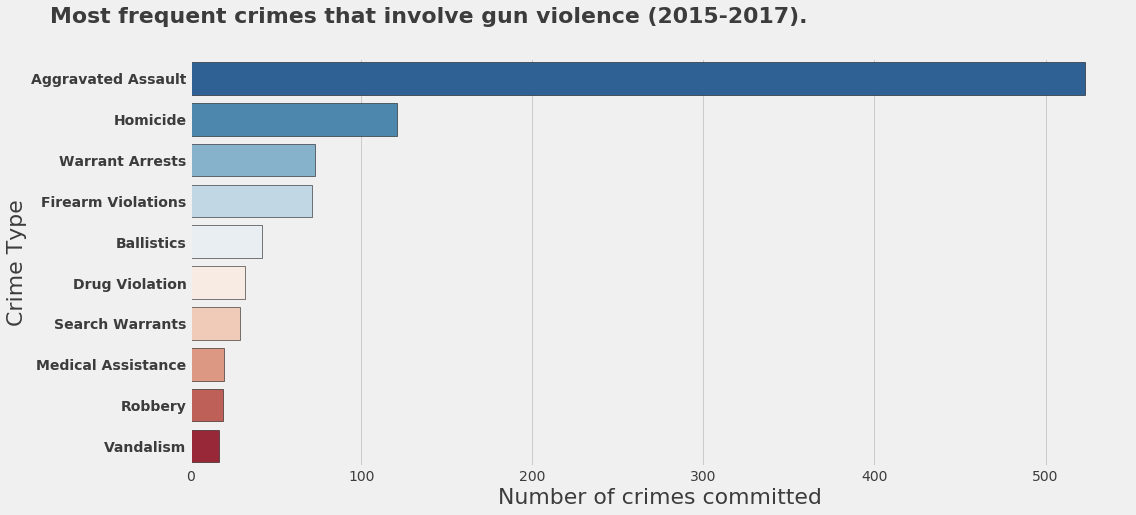

In [25]:
ax,fig = plt.subplots(figsize=(15,7))

#Plot
sns.countplot(y = top_gun_crimes["OFFENSE_CODE_GROUP"], order=crimes_with_guns.index, data=top_gun_crimes, palette="RdBu_r",edgecolor="black")

plt.ylabel("Crime Type", fontsize=22, alpha=.75)
plt.xlabel("Number of crimes committed", fontsize=22, alpha=.75)

plt.yticks(alpha=0.75,weight="bold")
plt.xticks(alpha=0.75)

#Title
ax.text(x=-0.05,y=0.95,s="Most frequent crimes that involve gun violence (2015-2017).",weight="bold",alpha=0.75, fontsize=22)

In [26]:
ten_freq_crimes = df["OFFENSE_CODE_GROUP"].value_counts()[:12]
df_top_crimes = df[df["OFFENSE_CODE_GROUP"].isin(ten_freq_crimes.index)]

In [27]:
df_tp = df_top_crimes.pivot_table(index=df_top_crimes["OCCURRED_ON_DATE"],
                                                      columns=["OFFENSE_CODE_GROUP"],aggfunc="size", fill_value=0).resample("M").sum()

Text(0.05, 0.95, 'Timeline of the most frequent crimes(2015-2018).')

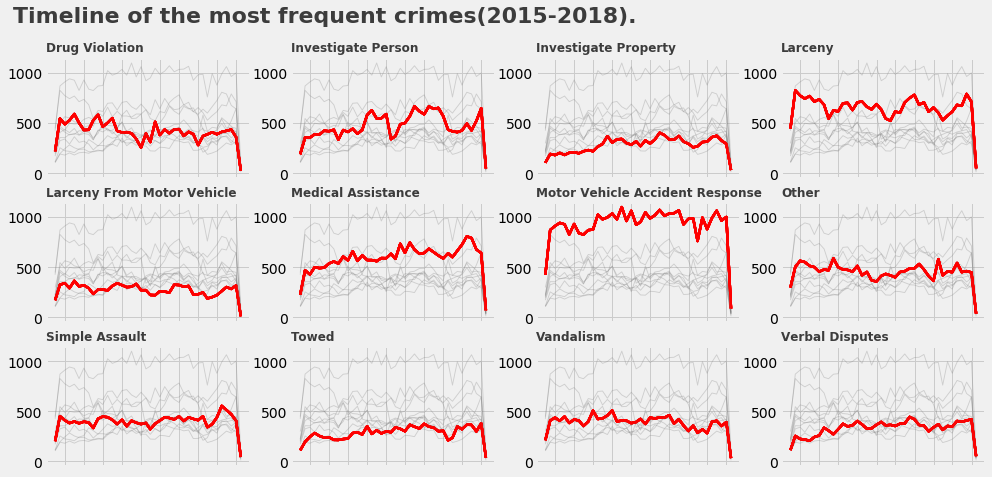

In [28]:
#palette = plt.get_cmap('Set2')
num=0
ax,fix = plt.subplots(figsize=(15,7))
for column in df_tp:
    num+=1
    plt.subplot(3,4, num)
    for v in df_tp:
        plt.plot(df_tp.index,v,data=df_tp,marker='', color='grey', linewidth=0.9, alpha=0.3)
        plt.tick_params(labelbottom=False)
        plt.plot(df_tp.index,column, data=df_tp,color="red", linewidth=2.4, alpha=0.75, label=column)
        plt.title(column, loc='left', fontsize=12, fontweight=0, color="black", alpha=0.75,weight="bold")
        #plt.suptitle("Most frequent crimes from 2015 - 2018", fontsize=20, fontweight=0, color='black', style='italic', y=1.02)
ax.text(x=0.05,y=0.95,s="Timeline of the most frequent crimes(2015-2018).",weight="bold",alpha=0.75, fontsize=22)

Most of the crimes behave differently over the years. While we can see some rise in the number of crimes committed from 2015 to 2018, the is no clear evidence that suggests that the Boston area is getting more dangerous.  One interesting insight that can be observed is that the number of Medical Assistance cases saw a rise over the years. We can observe a similar trend with the Investigate Person crime type.

**EDA Conclusions**


* We can fairly certainly say that holidays and temperature have a big impact on the number of crimes committed.
* Most of the crime happens on Friday, while the least happens on Sunday.
* The most frequent "crime" in Boston are Motor Vehicle Accidents while the second most are Larcenies.
* Guns are mostly used in Aggravated Assault followed by Homicides.
* Most of the crime happens around the Boston Downtown Crossing, Boston Commons and below.


Thank you for your time. Constructive feedback is always welcome.